# Neural Nets from Scratch: Predicting movie genres

- Prepares data by binarizing outputs (multilabel)
- Tries different neural nets

Dependencies: 
- posters in 2011-2016
- add_imdb_utf8_fixruntime_cleaned
- **ADD THE OTHER DATASET**


Here, I designed several neural nets to predict movie genres from posters. 



In [46]:
import numpy as np
import pandas as pd
import cv2  #package for image display
import pickle
from random import shuffle
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss

In [47]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D
from keras.optimizers import SGD, Adam
from keras import backend as K

import h5py

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Loading Posters and Binarizing Outputs

In [48]:
# read the data
data = pd.read_csv("add_imdb_utf8_fixruntime_cleaned.csv")
# data = pd.read_csv("Milestone3/add_imdb_utf8_fixruntime_cleaned.csv")

data.shape

# extract movies with poster information
index = np.zeros(data.shape[0])

for i in range(data.shape[0]):
    try:
        np.isnan(data.iloc[i, 0])
    except:
        index[i] = 1
        
print ("There are {} movies without poster.".format(np.sum(index == 0)))

# extract data with poster
data_with_poster = data.iloc[index == 1, ]
print ("Final data dimension:")
data_with_poster.shape

There are 103 movies without poster.
Final data dimension:


(5893, 39)

In [49]:
###### read each image and resize 

# total number of posters
n = data_with_poster.shape[0]

# target image size
target_length = 180
target_width = 128

# np.array to store the whole matrix in the order of the movie id
img_matrix = np.zeros([n, target_length, target_width, 3])

for i in range(n):
    if i % 1000 == 0:    
        print (i)    
    
    movie_id = data_with_poster["id"].values[i]
    
    path = 'posters_2011_2016/' + str(movie_id) + '.jpg'
    
    # read image
    img = cv2.imread(path)
    
    # normalize the image[-1,1], center at 0
    # so that the zero padding does not affect the image
    im = img.astype('float32')
    img = (img - 255/2)/255
    
    # extract the length and width of the image
    img_length, img_width = np.asarray(img.shape[:2])

    
    ## put the image to the center of the array
    # calcuate location of the left edge
    left_loc = int(0.5*(target_width - img_width))
    # calcuate location of the top edge
    top_loc = int(0.5*(target_length - img_length))
    
    # store the image
    img_matrix[i, top_loc:(top_loc+img_length), 
               left_loc:(left_loc+img_width), :] = img
    
print ("Final data shape:")
img_matrix.shape

0
1000
2000
3000
4000
5000
Final data shape:


(5893, 180, 128, 3)

In [50]:
# reformat the data shape
if K.image_data_format() == 'channels_first':
    img_matrix = img_matrix.reshape(n, 3, target_length, target_width)
    input_shape = (3, target_length, target_width)
else:
    img_matrix = img_matrix.reshape(n, target_length, target_width, 3)
    input_shape = (target_length, target_width, 3)

print('data shape:', img_matrix.shape)

data shape: (5893, 180, 128, 3)


In [51]:
### extract and clean the response variable 
# convert genre ids to list
y = list()
for i in range(data_with_poster.shape[0]):
    genre = map(int, re.sub("[\[ \] ]", "", data['genre_ids'][i]).split(','))
    y.append(genre)

# binarize response variable (returns array)
y_binary = MultiLabelBinarizer().fit_transform(y)
num_classes = 20

In [52]:
### split the train and test data
# shuffle the samples
seed = 109
index_2 = range(n)
shuffle(index_2)

img_matrix = img_matrix[index_2]
y_binary = y_binary[index_2]

# use the training data to fit the model
split_ratio = 0.9
split_num = int(n * split_ratio)

x_train = img_matrix[:split_num]
x_test = img_matrix[split_num:]

y_train = y_binary[:split_num]
y_test = y_binary[split_num:]

In [53]:
### Get random subset of x_train, y_train: use this for overfitting models

n_subset = 500

index_small_subset = range( int(n*split_ratio))
shuffle(index_small_subset)
# print (index_small_subset[:5])

x_train_subset = x_train[index_small_subset[:n_subset]]
print (x_train_subset.shape)
y_train_subset = y_train[index_small_subset[:n_subset] ]
print (y_train_subset.shape)


(500, 180, 128, 3)
(500, 20)


In [54]:
def overfit_model (model, x_subset, y_subset, optimizer_type, loss = 'binary_crossentropy', batch_size_ = 10, n_epochs = 30, plot = False):
    model.compile(loss= loss,
              optimizer = optimizer_type,
              metrics=['accuracy'])

    model_overfit = model.fit(x_subset, y_subset,
                    batch_size = batch_size_,
                    epochs = n_epochs,
                    verbose= 0,
                    validation_split=0.3)
    if plot == True:
        plt.plot(model_overfit.history['loss'])
        plt.xlabel("epoch")
        plt.ylabel("loss")
    min_loss = min(model_overfit.history['loss'])
    return min_loss

## Assess performance of Baseline (All Zeros)

Given that our labels are **sparse**, in that each movie has on average two genres out of many, we should assess the performance of the baseline model that **predicts all zeros** (no positive labels) for any sample points. Because a classifier that predicts all zeros has a high accuracy (~0.9), 

In [55]:
### What happens if we just predict all zeros:
y_zeros = np.zeros(y_binary.shape)
y_zeros.shape

print (classification_report(y_binary, y_zeros))
print ('Accuracy if all zeros:', (np.mean(y_binary == y_zeros)))
print('Hamming Loss if all zeros:', hamming_loss(y_binary, y_zeros))
print ('Binary Crossentropy Loss if all zeros:', log_loss(y_binary, y_zeros))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       361
          1       0.00      0.00      0.00       264
          2       0.00      0.00      0.00       335
          3       0.00      0.00      0.00      2141
          4       0.00      0.00      0.00       838
          5       0.00      0.00      0.00       763
          6       0.00      0.00      0.00      1469
          7       0.00      0.00      0.00       123
          8       0.00      0.00      0.00        55
          9       0.00      0.00      0.00      1135
         10       0.00      0.00      0.00       390
         11       0.00      0.00      0.00       896
         12       0.00      0.00      0.00       416
         13       0.00      0.00      0.00       266
         14       0.00      0.00      0.00       281
         15       0.00      0.00      0.00       639
         16       0.00      0.00      0.00       457
         17       0.00      0.00      0.00   

Therefore, a classifier that predicts all zeros has a very high accuracy of 0.9, a high hamming loss of 0.95, and a very high binary crossentropy loss. We decided to assess **accuraccy and binary cross entropy below while fitting our neural nets**. 

In [45]:
# ### Data Augmentation
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# # https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)

# # this is the augmentation configuration we will use for testing:
# # only rescaling
# test_datagen = ImageDataGenerator(rescale=1./255)
# train_generator  = train_datagen.fit(x_train)
# test_generator = test_datagen.fit(x_test)

# Neural Nets from Scratch

To determine whether custom neural nets have a sufficient number of parameters to fit our data, we should first try **overfitting the nets on a small subset of the data**. This is an important first step to perform before tuning our models, because failure to fit may indicate that the model is insufficient to fit the data, and thus we should look at other more complex models. We subsetted the first 500 sample points from our data and trained our model for a certain number of epochs until the training loss stopped declining. Because our goal here is to overfit the training data, I excluded dropout layers for this step. 

Source: https://datascience.stackexchange.com/questions/15602/training-my-neural-network-to-overfit-my-training-dataset

In [16]:
# Set Batch Size, Epochs, Learning Rate
batch_size = 10
epochs = 10
learning_rate = 0.01

## Simple Convolutional Neural Net

Our first model has 1 layer of dimension 16 and a kernel size of 3x3. 

In [56]:
### Simple: 1 layer, see if it runs

# create an empty network model
model1 = Sequential()

# --- input layer ---
model1.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# --- max pool ---
model1.add(MaxPooling2D(pool_size=(2, 2)))

# flatten for fully connected classification layer ( convert convolutional layer to dense layer)
model1.add(Flatten())

# --- fully connected layer ---
model1.add(Dense(32, activation='relu'))
# model1.add(Dropout(0.2))
model1.add(Dense(16, activation='relu'))
# model1.add(Dropout(0.2))

# --- classification ---: use softmax for multil
model1.add(Dense(num_classes, activation='softmax'))

# prints out a summary of the model architecture
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 178, 126, 16)      448       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 89, 63, 16)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 89712)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2870816   
_________________________________________________________________
dense_32 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_33 (Dense)             (None, 20)                340       
Total params: 2,872,132.0
Trainable params: 2,872,132.0
Non-trainable params: 0.0
____________________________________________________________

In [62]:
### Overfit model on small dataset
# overfit_model(model1, x_train_subset, y_train_subset, SGD(lr = 0.1, momentum=0.9))

model1.compile(loss = 'binary_crossentropy',
          optimizer = SGD(lr = 0.01, momentum=0.9),
          metrics=['accuracy'])

model1_overfit = model1.fit(x_train_subset, y_train_subset,
                batch_size = 10,
                epochs = 50,
                verbose = 0)

In [63]:
model1_overfit.history

{'acc': [0.94250000834465031,
  0.94180001378059386,
  0.9413000071048736,
  0.94130000829696658,
  0.94110000848770137,
  0.94110000014305117,
  0.94120000600814824,
  0.9413000071048736,
  0.94090000867843626,
  0.94120000839233398,
  0.94090001106262211,
  0.94030000090599064,
  0.94039999604225155,
  0.94110000014305117,
  0.9405000066757202,
  0.94050001382827764,
  0.94070000171661372,
  0.93970000743865967,
  0.94019999742507931,
  0.9403999984264374,
  0.93989999890327458,
  0.94010000705718999,
  0.93969999909400936,
  0.93969999909400936,
  0.93980001330375673,
  0.94020001173019407,
  0.93960000991821291,
  0.93950000286102298,
  0.93980000972747801,
  0.93970000267028808,
  0.93950000166893011,
  0.93990001320838923,
  0.93930000662803648,
  0.93939999938011165,
  0.94040001153945918,
  0.94050000429153446,
  0.93960000276565547,
  0.93950000047683713,
  0.9396999979019165,
  0.9401000022888184,
  0.93930000305175776,
  0.93950001358985902,
  0.94000000715255738,
  0.939300

500/500 [==============================] - 2s     


[0.072661866396665567, 0.9395999865531921]

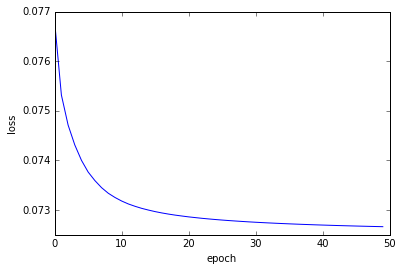

In [64]:
plt.plot(model1_overfit.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

# Evaluate on trainnig set: loss and accuracy
model1.evaluate(x_train_subset, y_train_subset)

- 1 layer neural net does not sufficiently overfit the data
- Get trend of decreasing loss, but flattens out for additional epochs
- May need a more complex model to describe data

## 2 Layer Convolutional Neural Net

- 2 layer convolutional neural net
- (Convolution + Pooling ) x 2

In [12]:
### 2 Layer Conv Net

# create an empty network model
model2 = Sequential()

# --- input layer ---
model2.add(Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
# --- max pool ---
model2.add(MaxPooling2D(pool_size=(2, 2)))
# model2.add(Dropout(0.2))

model2.add(Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
# --- max pool ---
model2.add(MaxPooling2D(pool_size=(2, 2)))
# model2.add(Dropout(0.2))


# flatten for fully connected classification layer ( convert convolutional layer to dense layer)
model2.add(Flatten())

# --- fully connected layer ---
model2.add(Dense(32, activation='relu'))
# model2.add(Dropout(0.2))
model2.add(Dense(16, activation='relu'))
# model2.add(Dropout(0.2))

# --- classification ---: use softmax for multil
model2.add(Dense(num_classes, activation='softmax'))

# prints out a summary of the model architecture
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 179, 127, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 63, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 88, 62, 16)        1040      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 44, 31, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 21824)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                698400    
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
__________

480/500 [===========================>..] - ETA: 0s

[0.089467400431632996, 0.94220013523101809]

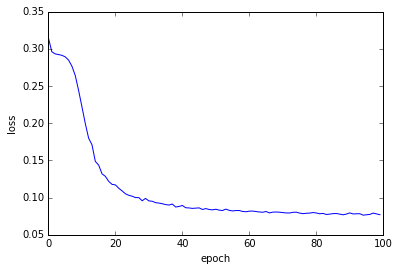

In [42]:
# overfit_model(model2, x_train_subset, y_train_subset, SGD(lr = 0.1, momentum=0.9))
model2.compile(loss = 'binary_crossentropy',
          optimizer = SGD(lr = 0.1, momentum=0.9),
          metrics=['accuracy'])

model2_overfit = model2.fit(x_train_subset, y_train_subset,
                batch_size = batch_size,
                epochs = 100,
                verbose = 0)

plt.plot(model2_overfit.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

# model1.evaluate(x_train_subset, y_train_subset)

Train on 3712 samples, validate on 1591 samples
Epoch 1/30
3712/3712 [==============================] - 7s - loss: 0.2940 - acc: 0.9046 - val_loss: 0.2927 - val_acc: 0.9056

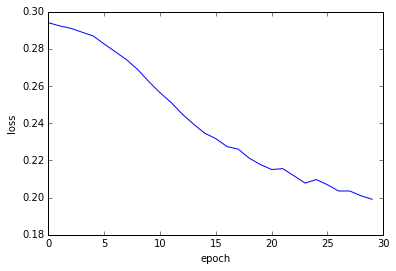

In [39]:
### FIT THE 2 layer MODEL, experimenting with larger batch size
history2_nostop = model2.fit(x_train, y_train,
                    batch_size= 128,
                    epochs= 30,
                    verbose=1,
                    validation_split=0.3)

plt.plot(history2_nostop.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

- Still has high loss, suggesting that changing batch size does not improve problems

## 4-Layer Convolutional Neural Net

In [ ]:
### MODEL FROM MNIST: https://github.com/suraj-deshmukh/Multi-Label-Image-Classification/blob/master/miml.ipynb
model4 = Sequential()
model4.add(Conv2D(32, 3, 3, border_mode='same',input_shape= input_shape))
model4.add(Activation('relu'))
model4.add(Conv2D(32, 3, 3))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

model4.add(Conv2D(64, 3, 3, border_mode='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(64, 3, 3))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

model4.add(Flatten())
model4.add(Dense(512))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))

# --- classification ---: use softmax for multil
model4.add(Dense(num_classes, activation='softmax'))

### complie and fit model
model4.compile(loss = 'binary_crossentropy',
          optimizer = SGD(lr = 0.1, momentum=0.9),
          metrics=['accuracy'])

model4_overfit = model.fit(x_train_subset, y_train_subset,
                batch_size = batch_size,
                epochs = 50,
                verbose = 1)

plt.plot(model4_overfit.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")


## 4 Layer net "Pyramid Scheme" 

- 4 layers: increasing n nodes from 64, 128, 256, 512

In [ ]:
### 64, 128, 256, 512 model

model_seq4 = Sequential()

model_seq4.add(Conv2D(64, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model_seq4.add(MaxPooling2D(pool_size=(2, 2)))
model_seq4.add(Conv2D(128, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model_seq4.add(MaxPooling2D(pool_size=(2, 2)))
model_seq4.add(Conv2D(256, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model_seq4.add(MaxPooling2D(pool_size=(2, 2)))
model_seq4.add(Conv2D(512, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model_seq4.add(MaxPooling2D(pool_size=(2, 2)))

# flatten for fully connected classification layer ( convert convolutional layer to dense layer)
model_seq4.add(Flatten())

# --- fully connected layer ---
model_seq4.add(Dense(32, activation='relu'))
model_seq4.add(Dense(16, activation='relu'))

# --- classification ---: use softmax for multil
model_seq4.add(Dense(num_classes, activation='sigmoid'))

# prints out a summary of the model architecture
model_seq4.summary()

model_seq4_overfit = model.fit(x_train_subset, y_train_subset,
                batch_size = batch_size,
                epochs = 50,
                verbose = 1)

plt.plot(model_seq4_overfit.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

500/500 [==============================] - 74s - loss: 0.0849 - acc: 0.9456     

## 5 Layer Model 

In [14]:
# 5 Layer Model
model_5layer = Sequential()

# Create 5 layers
for i in range(5):
    # --- input layer ---
    model_5layer.add(Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
    # --- max pool ---
    model_5layer.add(MaxPooling2D(pool_size=(2, 2)))
#     model_5layer.add(Dropout(0.2))


# flatten for fully connected classification layer ( convert convolutional layer to dense layer)
model_5layer.add(Flatten())

# --- fully connected layer ---
model_5layer.add(Dense(32, activation='relu'))
# model_5layer.add(Dropout(0.2))
model_5layer.add(Dense(16, activation='relu'))
# model_5layer.add(Dropout(0.2))

# --- classification ---: use softmax for multil
model_5layer.add(Dense(num_classes, activation='softmax'))

# prints out a summary of the model architecture
model_5layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 179, 127, 16)      208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 89, 63, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 88, 62, 16)        1040      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 44, 31, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 43, 30, 16)        1040      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 21, 15, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 14, 16)        1040      
__________

500/500 [==============================] - 0s     


[0.2510709092617035, 0.90930014991760255]

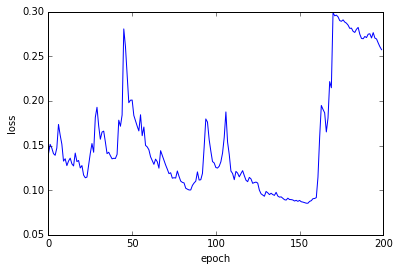

In [47]:
model_5layer.compile(loss = 'binary_crossentropy',
          optimizer = SGD(lr = 0.1, momentum=0.9),
          metrics=['accuracy'])

model_5layer_overfit = model_5layer.fit(x_train_subset, y_train_subset,
                batch_size = batch_size,
                epochs = 200,
                verbose = 0)

plt.plot(model_5layer_overfit.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

model_5layer.evaluate(x_train_subset, y_train_subset)

- Depsite training for large number of epochs, loss is not going down
- Suggests that model fails to fit the training data (underfit) -> try other architectures

## 5 Layer model with additional dense layers

In [15]:
### 5 Layer Model with more perceptron hidden layers
model_5layer_more = Sequential()

# Create 5 layers
for i in range(5):
    # --- input layer ---
    model_5layer_more.add(Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
    # --- max pool ---
    model_5layer_more.add(MaxPooling2D(pool_size=(2, 2)))
#     model_5layer.add(Dropout(0.2))


# flatten for fully connected classification layer ( convert convolutional layer to dense layer)
model_5layer_more.add(Flatten())

# --- fully connected layers ---
model_5layer_more.add(Dense(32, activation='relu'))
# model_5layer.add(Dropout(0.2))
model_5layer_more.add(Dense(32, activation='relu'))
# model_5layer.add(Dropout(0.2))

model_5layer_more.add(Dense(16, activation='relu'))
# model_5layer.add(Dropout(0.2))
model_5layer_more.add(Dense(16, activation='relu'))
# model_5layer.add(Dropout(0.2))

# --- classification ---: use softmax for multil
model_5layer_more.add(Dense(num_classes, activation='softmax'))

# prints out a summary of the model architecture
model_5layer_more.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 179, 127, 16)      208       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 89, 63, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 88, 62, 16)        1040      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 44, 31, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 43, 30, 16)        1040      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 21, 15, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 20, 14, 16)        1040      
__________

500/500 [==============================] - 0s     


[0.07850525593757629, 0.94300012969970703]

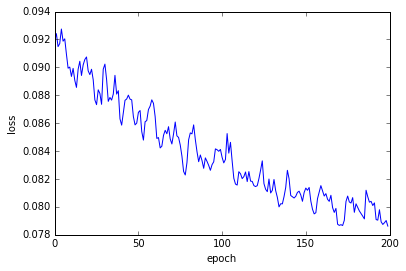

In [52]:
model_5layer_more
model_5layer_more.compile(loss = 'binary_crossentropy',
          optimizer = SGD(lr = 0.01, momentum=0.9),
          metrics=['accuracy'])

model_5layer_more_overfit = model_5layer_more.fit(x_train_subset, y_train_subset,
                batch_size = batch_size,
                epochs = 200,
                verbose = 0)

plt.plot(model_5layer_more_overfit.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

model_5layer_more.evaluate(x_train_subset, y_train_subset)

- Ran 5 layer model for a large number of epochs, but descent is slow and the loss is still high
- Learning rate is low but the slowly decreasing trend as well as fluctuations suggests taht the model might just be underfit

## 16-layer model

In [39]:
model_huge = Sequential()
model_huge.add(ZeroPadding2D((1,1),input_shape= input_shape))
model_huge.add(Conv2D(64, 3, 3, activation='relu'))
model_huge.add(ZeroPadding2D((1,1)))
model_huge.add(Conv2D(64, 3, 3, activation='relu'))
model_huge.add(MaxPooling2D((2,2), strides=(2,2)))

model_huge.add(ZeroPadding2D((1,1)))
model_huge.add(Conv2D(128, 3, 3, activation='relu'))
model_huge.add(ZeroPadding2D((1,1)))
model_huge.add(Conv2D(128, 3, 3, activation='relu'))
model_huge.add(MaxPooling2D((2,2), strides=(2,2)))

model_huge.add(ZeroPadding2D((1,1)))
model_huge.add(Conv2D(256, 3, 3, activation='relu'))
model_huge.add(ZeroPadding2D((1,1)))
model_huge.add(Conv2D(256, 3, 3, activation='relu'))
model_huge.add(ZeroPadding2D((1,1)))
model_huge.add(Conv2D(256, 3, 3, activation='relu'))
model_huge.add(MaxPooling2D((2,2), strides=(2,2)))

model_huge.add(ZeroPadding2D((1,1)))
model_huge.add(Conv2D(512, 3, 3, activation='relu'))
model_huge.add(ZeroPadding2D((1,1)))
model_huge.add(Conv2D(512, 3, 3, activation='relu'))
model_huge.add(ZeroPadding2D((1,1)))
model_huge.add(Conv2D(512, 3, 3, activation='relu'))
model_huge.add(MaxPooling2D((2,2), strides=(2,2)))

model_huge.add(ZeroPadding2D((1,1)))
model_huge.add(Conv2D(512, 3, 3, activation='relu'))
model_huge.add(ZeroPadding2D((1,1)))
model_huge.add(Conv2D(512, 3, 3, activation='relu'))
model_huge.add(ZeroPadding2D((1,1)))
model_huge.add(Conv2D(512, 3, 3, activation='relu'))
model_huge.add(MaxPooling2D((2,2), strides=(2,2)))

model_huge.add(Flatten())
model_huge.add(Dense(1024, activation='relu'))
model_huge.add(Dropout(0.5))
model_huge.add(Dense(1024, activation='relu'))
model_huge.add(Dropout(0.5))
model_huge.add(Dense(num_classes, activation='sigmoid'))


/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  app.launch_new_instance()
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Conv2D`

In [ ]:
model_huge.compile(loss = 'binary_crossentropy',
          optimizer = SGD(lr = 0.1, momentum=0.9),
          metrics=['accuracy'])

model_huge_overfit = model_huge.fit(x_train_subset, y_train_subset,
                batch_size = batch_size,
                epochs = 10,
                verbose = 1)

plt.plot(model_huge_overfit.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

model_huge.evaluate(x_train_subset, y_train_subset)

Epoch 1/10
500/500 [==============================] - 594s - loss: 0.2891 - acc: 0.9035     

In [44]:
model_huge_overfit.history

{'acc': [0.90349998235702511,
  0.90419997572898869,
  0.90559998273849485,
  0.9042999708652496,
  0.90519997835159305,
  0.90589997887611384,
  0.90519997835159305,
  0.90589998245239256,
  0.90589997053146365,
  0.90589997649192811],
 'loss': [0.28910998910665514,
  0.28458219528198242,
  0.28322667777538302,
  0.2828706866502762,
  0.28160423517227173,
  0.27883580327033997,
  0.27958765506744387,
  0.27813379019498824,
  0.27805606871843336,
  0.27922897011041642]}

- Loss is very high for this model 

In [17]:
# weights = np.ones((y_train_subset.shape[1]))
# weights.shape

(20,)

500/500 [==============================] - 1s     


[0.07675183963775635, 0.94450012969970698]

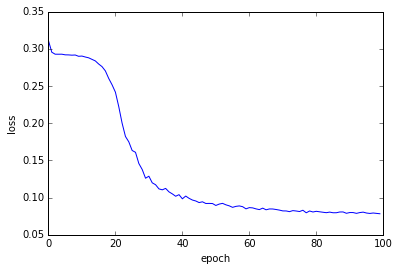

In [44]:
# overfit_model(model_seq, x_train_subset, y_train_subset, SGD(lr = 0.01, momentum=0.9))

model_seq.compile(loss = 'binary_crossentropy',
          optimizer = SGD(lr = 0.1, momentum=0.9),
          metrics=['accuracy'])

model_seq_overfit = model_seq.fit(x_train_subset, y_train_subset,
                batch_size = batch_size,
                epochs = 100,
                verbose = 0)

plt.plot(model_seq_overfit.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

model_seq.evaluate(x_train_subset, y_train_subset)

## 5 Layer Neural Network 

Train on 70 samples, validate on 30 samples
Epoch 1/30
70/70 [==============================] - 0s - loss: 0.3396 - acc: 0.9021 - val_loss: 0.3592 - val_acc: 0.8950
Epoch 2/30
70/70 [==============================] - 0s - loss: 0.3378 - acc: 0.9021 - val_loss: 0.3565 - val_acc: 0.8950
Epoch 3/30
70/70 [==============================] - 0s - loss: 0.3349 - acc: 0.9021 - val_loss: 0.3534 - val_acc: 0.8950
Epoch 4/30
70/70 [==============================] - 0s - loss: 0.3316 - a

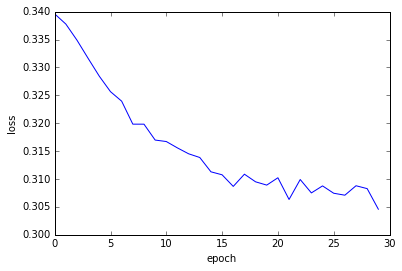

In [90]:
### Overfit model on small dataset
overfit_model(model_5layer, x_train_subset, y_train_subset, SGD(lr = 0.1, momentum=0.9))

### Loss by Training Epoch

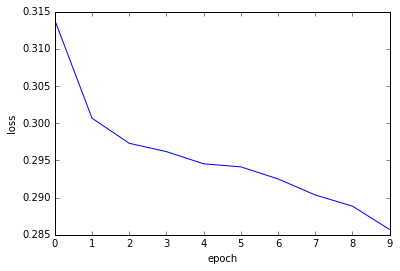

In [29]:
plt.plot(history.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

### Validation Accuracy by Training Epoch

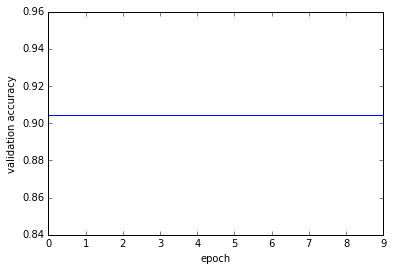

In [30]:
plt.plot(history.history['val_acc'])
plt.xlabel("epoch")
plt.ylabel("validation accuracy")

In [20]:
### Just try on full dataset first
y_pred_prob_small = model.predict(img_matrix)
print ('y pred prob shape:', y_pred_prob_small.shape)

# Print 1 value
print (y_pred_prob_small[5])

y pred prob shape: (5893, 20)
5893/5893 [==============================] - 4s     

- https://github.com/fchollet/keras/blob/ac1a09c787b3968b277e577a3709cd3b6c931aa5/tests/keras/test_metrics.py

### Model 2: Simple (2 layer) Convolutional Neural Net

In [26]:
### Compare 1 to 2 layer

# create an empty network model
model2 = Sequential()

# --- input layer ---
model2.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# --- max pool ---
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# --- input layer ---
model2.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# --- max pool ---
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))


# flatten for fully connected classification layer ( convert convolutional layer to dense layer)
model2.add(Flatten())

# --- fully connected layer ---
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.2))

# --- classification ---: use softmax for multil
model2.add(Dense(num_classes, activation='softmax'))

# prints out a summary of the model architecture
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 178, 126, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 89, 63, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 89, 63, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 87, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 43, 30, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 43, 30, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20640)             0         
__________

In [38]:
### COMPILE THE MODEL
# Backpropagation with Stochastic Gradient Descent: 
sgd = SGD(lr = learning_rate, momentum=0.9)

# Backprop with Adam
adam = Adam()
model2.compile(loss='binary_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])

- Slow decline of loss by epoch suggests that learning rate may be too low
- Create model with very high learning rate

In [41]:
# Backpropagation with Stochastic Gradient Descent: 
sgd_high_lr = SGD(lr = 0.1, momentum=0.9)

model2.compile(loss ='binary_crossentropy',
              optimizer = sgd_high_lr,
              metrics = ['accuracy'])

history2_nostop_highlr = model2.fit(x_train, y_train,
                    batch_size= 128,
                    epochs= 20,
                    verbose=1,
                    validation_split=0.3)

Train on 3712 samples, validate on 1591 samples
Epoch 1/20
3712/3712 [==============================] - 7s - loss: 0.1965 - acc: 0.9225 - val_loss: 0.3652 - val_acc: 0.9014

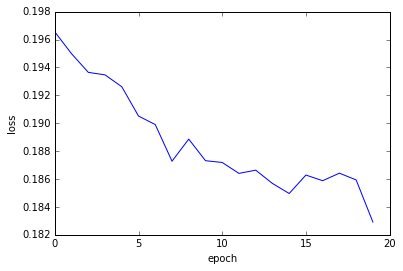

In [42]:
plt.plot(history2_nostop_highlr.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

In [ ]:
# Predict on test
y_predict_2 = model2.predict(x_test)